#### About Dataset
Skin Cancer: Malignant vs Benign

This dataset contains a balanced dataset of images of benign skin moles and malignant skin moles.

https://www.kaggle.com/datasets/fanconic/skin-cancer-malignant-vs-benign

#### Content
The data consists of two folders with each 1800 pictures (224x244) of the two types of moles.

The data in this dataset is subject to the rights of ISIC-Archive (https://www.isic-archive.com/#!/topWithHeader/wideContentTop/main). I want to clarify that I do not bear any responsibility for any infringement of rights that may occur in relation to the use of this data. Therefore, it is important to refrain from monetizing any models or projects based on this dataset to avoid any potential legal issues.

The code imports necessary libraries and modules for machine learning and deep learning tasks, including PyTorch, scikit-learn, and matplotlib. It also sets a random seed for reproducibility.

In [ ]:
# The bellow imports various libraries and modules necessary for the code.

import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import KFold 
 
import seaborn as sns
# Set seed for reproducibility
torch.manual_seed(11)

The code defines a dataset class called "SkinCancerDataset" for loading skin cancer images. It loads the images from a given folder, assigns labels to each image based on whether it is classified as "malignant" or not, and provides methods for retrieving the images and labels. The class implements the len and getitem methods required for a PyTorch dataset.

In [2]:
# Define dataset class
class SkinCancerDataset(Dataset):
    def __init__(self, folder, transform=None):
        self.folder = folder
        self.transform = transform
        self.images = []  # List to store image paths
        self.labels = []  # List to store corresponding labels
        self._load_images()  # Call the private method to load images

    def _load_images(self):
        for label in os.listdir(self.folder):  # Iterate over folders in the main directory
            label_folder = os.path.join(self.folder, label)  # Path to the current label folder
            if os.path.isdir(label_folder):  # Check if it's a directory
                for image_file in os.listdir(label_folder):  # Iterate over files in the label folder
                    image_path = os.path.join(label_folder, image_file)  # Path to the current image
                    self.images.append(image_path)  # Add image path to the list
                    self.labels.append(int(label == 'malignant'))  # Add label (1 for 'malignant', 0 for others)

    def __len__(self):
        return len(self.images)  # Return the total number of images in the dataset

    def __getitem__(self, index):
        image_path = self.images[index]  # Get the path of the image at the given index
        image = Image.open(image_path).convert("RGB")  # Open the image and convert it to RGB format
        label = self.labels[index]  # Get the corresponding label for the image
        if self.transform:  # Check if any transformations are provided
            image = self.transform(image)  # Apply the transformations to the image
        return image, label  # Return the transformed image and its label


The code defines a set of data transformations including resizing, tensor conversion, and normalization using mean and standard deviation values.

In [3]:
# Define data transformations
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

The code defines the paths to the train and test folders as folder_train and folder_test, respectively.

In [4]:
# Define paths to train and test folders
folder_train = 'archive/data/train'
folder_test = 'archive/data/test'

The code creates train and test datasets by instantiating the SkinCancerDataset class with the respective train and test folders and applying the defined data transformations.

In [5]:
# Create train and test datasets
train_dataset = SkinCancerDataset(folder_train, transform=data_transforms)
test_dataset = SkinCancerDataset(folder_test, transform=data_transforms)

In [6]:
# Split dataset into train and validation sets
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size

train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

In [7]:
# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

The code displays a grid of sample images from the dataset using matplotlib.

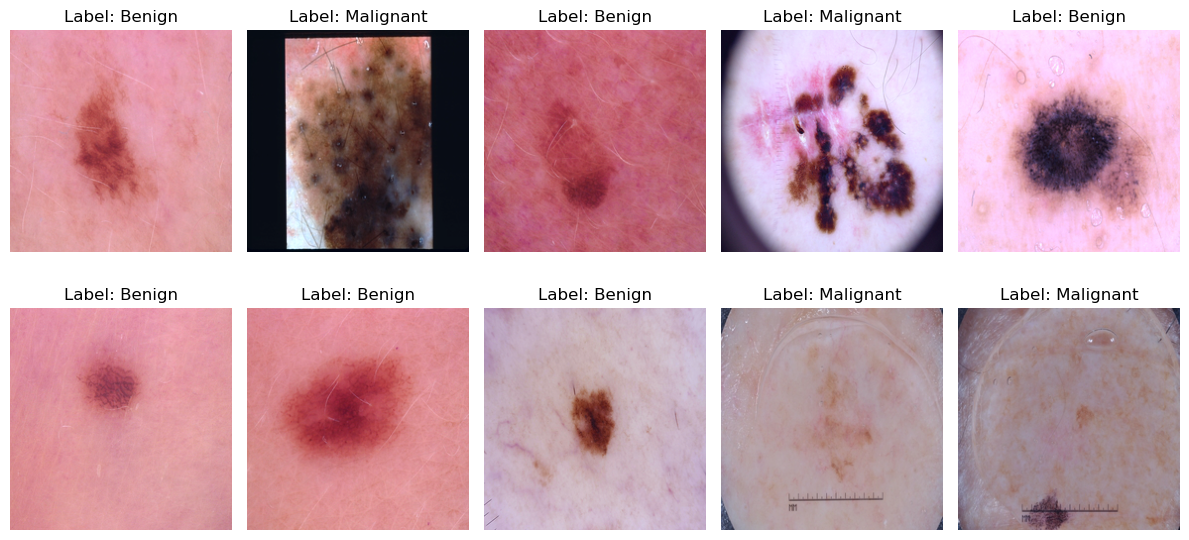

In [8]:
# Show sample images from the dataset
fig, axs = plt.subplots(2, 5, figsize=(12, 6))
axs = axs.flatten()

for i in range(10):
    image, label = train_dataset[i]
    image = image.permute(1, 2, 0).numpy()  # Convert tensor to numpy array and change the dimension order
    image = (image * 0.229 + 0.485).clip(0, 1)  # Unnormalize the image
    
    axs[i].imshow(image)
    axs[i].set_title(f"Label: {'Malignant' if label == 1 else 'Benign'}")
    axs[i].axis('off')

plt.tight_layout()
plt.show()

The code defines a CNN model architecture for skin cancer classification. It consists of two convolutional layers, each followed by ReLU activation and max pooling. The output is then flattened and passed through two fully connected layers with ReLU activation. The model's forward method applies these operations sequentially.

In [9]:
# Input (3 channels)
#    |
#    |--> Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
#    |--> ReLU()
#    |--> MaxPool2d(kernel_size=2, stride=2)
#    |--> Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
#    |--> ReLU()
#    |--> MaxPool2d(kernel_size=2, stride=2)
#    |--> Flatten()
#    |--> Linear(64 * 56 * 56, 128)
#    |--> ReLU()
#    |--> Linear(128, 2)
#    |
# Output (2 classes)

# Define CNN model architecture
class SkinCancerModel(nn.Module):
    def __init__(self):
        super(SkinCancerModel, self).__init__()
        
        # First Convolutional Layer: input channels=3, output channels=32, kernel size=3x3, stride=1, padding=1
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)        
        # ReLU activation after the first convolutional layer
        self.relu1 = nn.ReLU()        
        # First Max Pooling Layer: kernel size=2x2, stride=2
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)        
        # Second Convolutional Layer: input channels=32, output channels=64, kernel size=3x3, stride=1, padding=1
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)        
        # ReLU activation after the second convolutional layer
        self.relu2 = nn.ReLU()        
        # Second Max Pooling Layer: kernel size=2x2, stride=2
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)    
        
        # Flatten layer to convert multi-dimensional output to a 1D tensor
        self.flatten = nn.Flatten()        
        # First Fully Connected Layer: input size=64*56*56, output size=128
        self.fc1 = nn.Linear(64 * 56 * 56, 128)        
        
        # ReLU activation after the first fully connected layer
        self.relu3 = nn.ReLU()        
        # Second Fully Connected Layer: input size=128, output size=2
        self.fc2 = nn.Linear(128, 2)
        
    def forward(self, x):
        x = self.conv1(x)      # Apply first convolutional layer
        x = self.relu1(x)      # Apply ReLU activation
        x = self.maxpool1(x)   # Apply first max pooling layer
        
        x = self.conv2(x)      # Apply second convolutional layer
        x = self.relu2(x)      # Apply ReLU activation
        x = self.maxpool2(x)   # Apply second max pooling layer
        
        x = self.flatten(x)    # Flatten the output
        x = self.fc1(x)        # Apply first fully connected layer
        
        x = self.relu3(x)      # Apply ReLU activation
        x = self.fc2(x)        # Apply second fully connected layer
        return x


The code creates a SkinCancerModel instance, defines the number of epochs as n_epochs, and initializes the optimizer and loss function in a single line.

In [10]:
# Create model instance
model = SkinCancerModel()

# Define epochs for trainning and validation 
n_epochs =50

# Define optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

The code defines a train function that trains the model using a specified optimizer, criterion, and number of epochs. It returns the training and validation losses as well as the training and validation accuracies.

In [11]:
# Train the model
def train(model, train_loader, optimizer, criterion, num_epochs):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Check if CUDA is available and set the device
    model.to(device)  # Move the model to the appropriate device (GPU or CPU)

    train_losses = []  # List to store training losses per epoch
    val_losses = []  # List to store validation losses per epoch
    train_accuracies = []  # List to store training accuracies per epoch
    val_accuracies = []  # List to store validation accuracies per epoch

    for epoch in range(num_epochs):  # Loop over the specified number of epochs
        model.train()  # Set the model in training mode
        running_loss = 0.0  # Variable to keep track of the running loss
        correct = 0  # Variable to keep track of the number of correct predictions
        total = 0  # Variable to keep track of the total number of samples

        for images, labels in train_loader:  # Iterate over the training data
            images, labels = images.to(device), labels.to(device)  # Move the input data to the appropriate device

            optimizer.zero_grad()  # Clear the gradients from previous iteration
            outputs = model(images)  # Forward pass to get the model predictions
            loss = criterion(outputs, labels)  # Calculate the loss
            loss.backward()  # Backward pass to compute gradients
            optimizer.step()  # Update the model parameters

            running_loss += loss.item()  # Accumulate the loss for the current batch
            _, predicted = torch.max(outputs.data, 1)  # Get the predicted labels
            total += labels.size(0)  # Update the total number of samples
            correct += (predicted == labels).sum().item()  # Count the number of correct predictions

        train_loss = running_loss / len(train_loader)  # Calculate the average training loss per batch
        train_accuracy = 100.0 * correct / total  # Calculate the training accuracy
        train_losses.append(train_loss)  # Store the training loss for the current epoch
        train_accuracies.append(train_accuracy)  # Store the training accuracy for the current epoch

        # Evaluate the model on the validation set
        val_loss, val_accuracy = evaluate(model, val_loader, criterion, device)
        val_losses.append(val_loss)  # Store the validation loss for the current epoch
        val_accuracies.append(val_accuracy)  # Store the validation accuracy for the current epoch

        # Print the training and validation metrics for the current epoch
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%")

    return train_losses, val_losses, train_accuracies, val_accuracies


The code defines an "evaluate" function to assess the model's performance using a data loader, criterion, and device. It computes the average loss and accuracy.

In [12]:
# Evaluate the model
def evaluate(model, data_loader, criterion, device):
    model.eval()  # Set the model in evaluation mode
    running_loss = 0.0  # Variable to keep track of the running loss
    correct = 0  # Variable to keep track of the number of correct predictions
    total = 0  # Variable to keep track of the total number of samples

    with torch.no_grad():  # Disable gradient calculation
        for images, labels in data_loader:  # Iterate over the data loader
            images, labels = images.to(device), labels.to(device)  # Move the input data to the appropriate device

            outputs = model(images)  # Forward pass to get the model predictions
            loss = criterion(outputs, labels)  # Calculate the loss

            running_loss += loss.item()  # Accumulate the loss for the current batch
            _, predicted = torch.max(outputs.data, 1)  # Get the predicted labels
            total += labels.size(0)  # Update the total number of samples
            correct += (predicted == labels).sum().item()  # Count the number of correct predictions

    loss = running_loss / len(data_loader)  # Calculate the average loss per batch
    accuracy = 100.0 * correct / total  # Calculate the accuracy

    return loss, accuracy


The model is trained using the train() function, and the training process tracks the train and validation losses as well as train and validation accuracies. 

In [13]:
# Train the model
train_losses, val_losses, train_accuracies, val_accuracies = train(model, train_loader, optimizer, criterion, num_epochs=n_epochs)

Epoch [1/50], Train Loss: 2.2871, Train Acc: 65.20%, Val Loss: 0.6022, Val Acc: 79.92%
Epoch [2/50], Train Loss: 0.5137, Train Acc: 75.96%, Val Loss: 0.3829, Val Acc: 81.82%
Epoch [3/50], Train Loss: 0.3793, Train Acc: 82.27%, Val Loss: 0.3682, Val Acc: 82.95%
Epoch [4/50], Train Loss: 0.3386, Train Acc: 83.59%, Val Loss: 0.3316, Val Acc: 84.66%
Epoch [5/50], Train Loss: 0.2633, Train Acc: 88.29%, Val Loss: 0.3239, Val Acc: 85.80%
Epoch [6/50], Train Loss: 0.2041, Train Acc: 91.37%, Val Loss: 0.3710, Val Acc: 82.20%
Epoch [7/50], Train Loss: 0.2058, Train Acc: 91.32%, Val Loss: 0.3311, Val Acc: 83.33%
Epoch [8/50], Train Loss: 0.1307, Train Acc: 95.50%, Val Loss: 0.3679, Val Acc: 85.04%
Epoch [9/50], Train Loss: 0.0821, Train Acc: 96.97%, Val Loss: 0.4224, Val Acc: 85.23%
Epoch [10/50], Train Loss: 0.0587, Train Acc: 98.44%, Val Loss: 0.4234, Val Acc: 87.50%
Epoch [11/50], Train Loss: 0.0496, Train Acc: 98.96%, Val Loss: 0.4875, Val Acc: 85.23%
Epoch [12/50], Train Loss: 0.0209, Train 

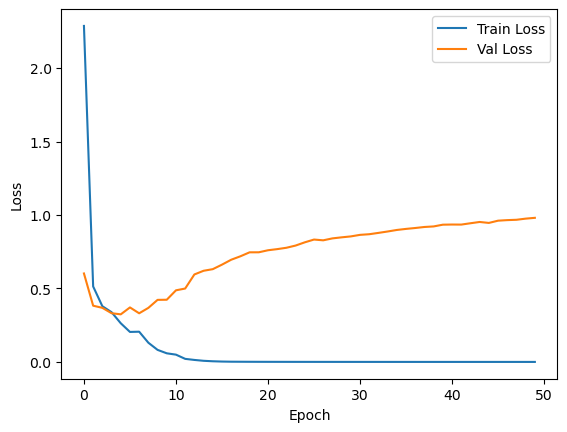

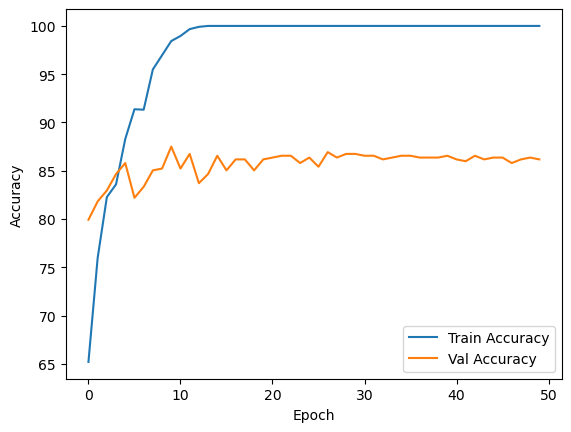

In [14]:
# Plot accuracy and loss curves
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

The code tests a model's performance and generates a confusion matrix for evaluation

Test Accuracy: 0.85


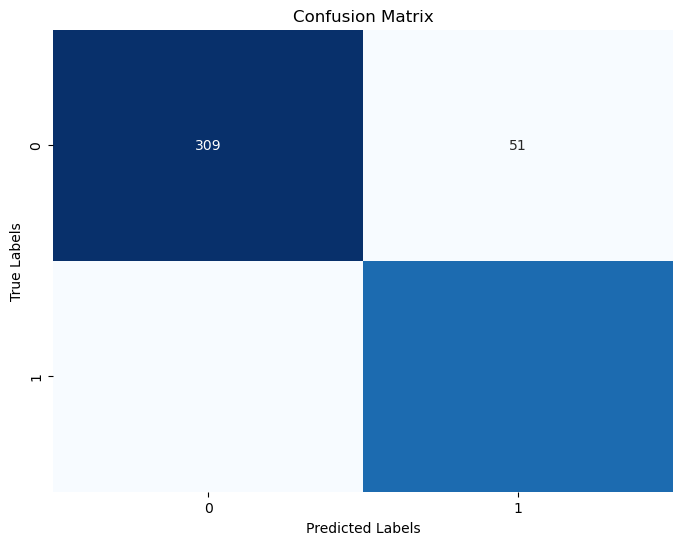

In [15]:
# Test the model
def test(model, test_loader, device):
    model.eval()  # Set the model in evaluation mode
    predictions = []  # List to store the predicted labels
    true_labels = []  # List to store the true labels

    with torch.no_grad():  # Disable gradient calculation
        for images, labels in test_loader:  # Iterate over the test loader
            images = images.to(device)  # Move the input data to the appropriate device

            outputs = model(images)  # Forward pass to get the model predictions
            _, predicted = torch.max(outputs.data, 1)  # Get the predicted labels

            predictions.extend(predicted.cpu().numpy())  # Add the predicted labels to the list
            true_labels.extend(labels.numpy())  # Add the true labels to the list

    return predictions, true_labels


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Check if CUDA is available and set the device
model.to(device)  # Move the model to the appropriate device

predictions, true_labels = test(model, test_loader, device)  # Test the model and get the predictions and true labels
accuracy = accuracy_score(true_labels, predictions)  # Calculate the test accuracy
print(f"Test Accuracy: {accuracy:.2f}")

# Generate confusion matrix
cm = confusion_matrix(true_labels, predictions)  # Calculate the confusion matrix

# Create a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))  # Set the figure size
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)  # Plot the heatmap
plt.xlabel("Predicted Labels")  # Set the label for the x-axis
plt.ylabel("True Labels")  # Set the label for the y-axis
plt.title("Confusion Matrix")  # Set the title of the plot
plt.show()  # Display the plot



The code saves the model's state dictionary to a file named "model.pt".

In [16]:
# Save the model
torch.save(model.state_dict(), "model.pt")
print("Saved model to disk")

Saved model to disk


The code performs cross-validation training for a specified number of folds and plots the average loss and accuracy curves.

Fold 1/3
Epoch [1/50], Train Loss: 1.8504, Train Acc: 62.45%, Val Loss: 0.5854, Val Acc: 76.14%
Epoch [2/50], Train Loss: 0.5022, Train Acc: 76.67%, Val Loss: 0.4213, Val Acc: 79.36%
Epoch [3/50], Train Loss: 0.4162, Train Acc: 79.02%, Val Loss: 0.3718, Val Acc: 80.87%
Epoch [4/50], Train Loss: 0.3449, Train Acc: 83.57%, Val Loss: 0.3277, Val Acc: 82.77%
Epoch [5/50], Train Loss: 0.2987, Train Acc: 86.42%, Val Loss: 0.3025, Val Acc: 84.66%
Epoch [6/50], Train Loss: 0.2498, Train Acc: 88.76%, Val Loss: 0.3539, Val Acc: 81.82%
Epoch [7/50], Train Loss: 0.2410, Train Acc: 89.62%, Val Loss: 0.3231, Val Acc: 84.28%
Epoch [8/50], Train Loss: 0.1923, Train Acc: 92.67%, Val Loss: 0.3302, Val Acc: 84.85%
Epoch [9/50], Train Loss: 0.1301, Train Acc: 95.31%, Val Loss: 0.3233, Val Acc: 86.36%
Epoch [10/50], Train Loss: 0.0902, Train Acc: 97.08%, Val Loss: 0.3547, Val Acc: 85.42%
Epoch [11/50], Train Loss: 0.0649, Train Acc: 97.94%, Val Loss: 0.4418, Val Acc: 83.52%
Epoch [12/50], Train Loss: 0.053

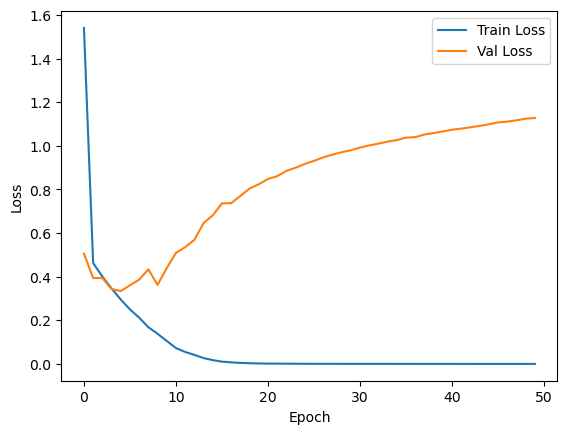

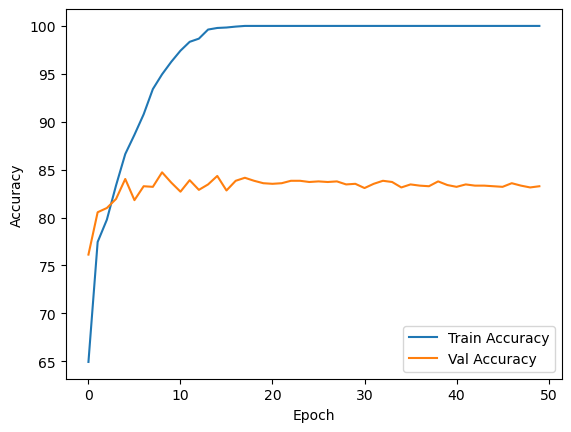

In [17]:


# Define number of folds for KFold cross-validation
num_folds = 3

# Create KFold instance
kf = KFold(n_splits=num_folds, shuffle=True, random_state=11)

# Create lists to store metrics for each fold
fold_train_losses = []
fold_val_losses = []
fold_train_accuracies = []
fold_val_accuracies = []

# Perform cross-validation
for fold, (train_index, val_index) in enumerate(kf.split(train_dataset)):
    print(f"Fold {fold+1}/{num_folds}")

    # Create train and validation datasets for the current fold
    train_dataset_fold = torch.utils.data.Subset(train_dataset, train_index)
    val_dataset_fold = torch.utils.data.Subset(train_dataset, val_index)

    # Create data loaders for the current fold
    train_loader_fold = DataLoader(train_dataset_fold, batch_size=64, shuffle=True)
    val_loader_fold = DataLoader(val_dataset_fold, batch_size=64, shuffle=False)

    # Create model instance
    model = SkinCancerModel()

    # Define optimizer and loss function
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.CrossEntropyLoss()

    # Train the model
    train_losses, val_losses, train_accuracies, val_accuracies = train(model, train_loader_fold, optimizer, criterion, num_epochs=n_epochs)

    # Save metrics for the current fold
    fold_train_losses.append(train_losses)
    fold_val_losses.append(val_losses)
    fold_train_accuracies.append(train_accuracies)
    fold_val_accuracies.append(val_accuracies)
    
    # Print metrics for the current fold
    print(f"Fold {fold+1} - Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.2f}%, "
          f"Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accuracies[-1]:.2f}%")


# Plot average accuracy and loss curves across folds
avg_train_losses = np.mean(fold_train_losses, axis=0)
avg_val_losses = np.mean(fold_val_losses, axis=0)
avg_train_accuracies = np.mean(fold_train_accuracies, axis=0)
avg_val_accuracies = np.mean(fold_val_accuracies, axis=0)

plt.plot(avg_train_losses, label='Train Loss')
plt.plot(avg_val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(avg_train_accuracies, label='Train Accuracy')
plt.plot(avg_val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


The code loads a saved model, preprocesses and predicts labels for a set of images in a folder, and displays the images with their predicted labels in a grid view.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

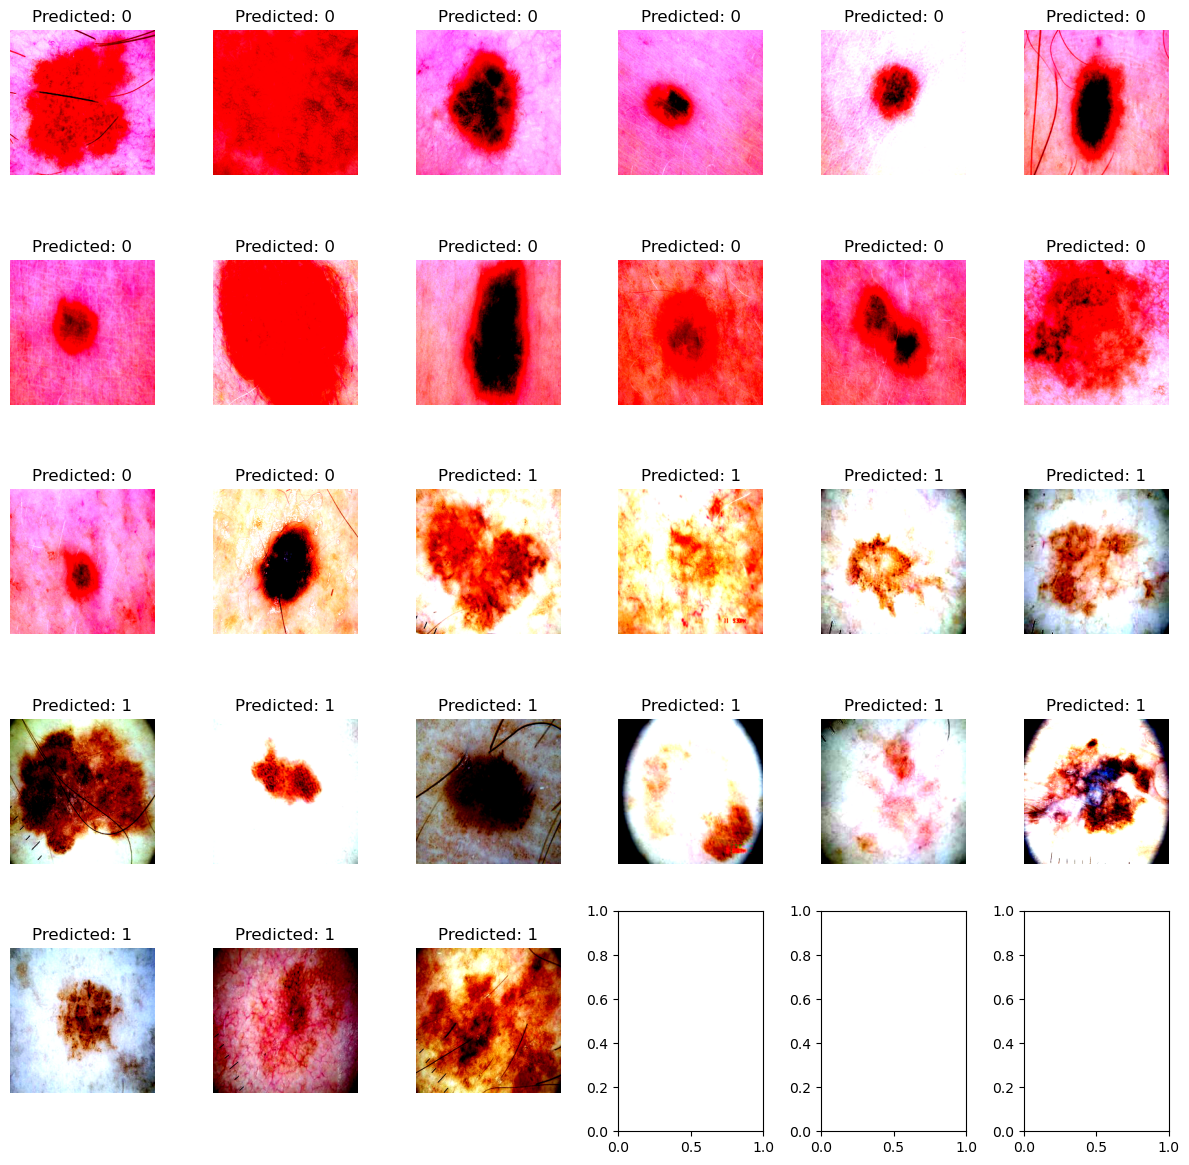

In [18]:


# Load the saved model
model = SkinCancerModel()
model.load_state_dict(torch.load("model.pt"))
model = model.to(device)  # Move the model to the appropriate device


# Define the path to the folder containing the images
folder_path = "archive/samples/"

# Calculate the number of rows and columns for the grid view
num_images = len(os.listdir(folder_path))
num_rows = int(num_images ** 0.5)
num_cols = (num_images + num_rows - 1) // num_rows

# Create a grid of subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 12))

# Iterate over the files in the folder
for i, filename in enumerate(os.listdir(folder_path)):
    # Preprocess the image
    image_path = os.path.join(folder_path, filename)
    sample_image = Image.open(image_path).convert("RGB")
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    sample_image = transform(sample_image)

    # Reshape the image to include a batch dimension
    sample_image = sample_image.unsqueeze(0)

    # Move the image tensor to the appropriate device
    sample_image = sample_image.to(device)

    # Perform the prediction
    with torch.no_grad():
        outputs = model(sample_image)
        _, predicted = torch.max(outputs.data, 1)
        predicted_label = predicted.item()

    # Display the image and predicted label in the corresponding subplot
    row = i // num_cols
    col = i % num_cols
    ax = axes[row, col]
    ax.imshow(sample_image.squeeze().permute(1, 2, 0).cpu())
    ax.set_title("Predicted: {}".format(predicted_label))
    ax.axis("off")

# Adjust the spacing between subplots and display the grid view
plt.tight_layout()
plt.show()



In [19]:
# Define function to calculate accuracy
def calculate_accuracy(model, data_loader, device):
    predictions, true_labels = test(model, data_loader, device)
    accuracy = accuracy_score(true_labels, predictions)
    return accuracy

# Calculate accuracy for training set
train_accuracy = calculate_accuracy(model, train_loader, device)
print("Training Set Accuracy: {:.2f}%".format(train_accuracy))

# Calculate accuracy for validation set
val_accuracy = calculate_accuracy(model, val_loader, device)
print("Validation Set Accuracy: {:.2f}%".format(val_accuracy))

# Calculate accuracy for testing set
test_accuracy = calculate_accuracy(model, test_loader, device)
print("Testing Set Accuracy: {:.2f}%".format(test_accuracy))

Training Set Accuracy: 1.00%
Validation Set Accuracy: 0.86%
Testing Set Accuracy: 0.85%
